In [ ]:
%load_ext autoreload
%autoreload 2

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils.functions as f

# Data Exploration

In [32]:
dataset = "reverse_matching_20240213"  # "direct_matching_20240213" or "reverse_matching_20240213"
is_reverse = True 

df_direct_matching = pd.read_csv(f"Data/{dataset}.csv", sep=";")
df_direct_matching.head()

,cand_id,job_id,distance_km,match_score,match_rank,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,cand_languages_spoken,job_contract_type,job_professional_category,job_sector,job_work_province
0,"11,208",OFF_3435_4864,30.609745,99.309860,1,Female,25-34,VE,VENETO,"Laurea Magistrale : Economia per arti, cultura...",Tedesco;Ebraico;Rumeno,Ricerca e selezione,segretario/segretaria,Segreteria / Servizi Generali,TV
1,"11,208",ORD_13361_0218,42.466312,96.529259,1,Female,25-34,VE,VENETO,"Laurea Magistrale : Economia per arti, cultura...",Tedesco;Ebraico;Rumeno,Lavoro subordinato,Impiegato (m/f),Segreteria / Servizi Generali,PN
2,"11,208",ORD_14183_0606,33.240650,95.374954,2,Female,25-34,VE,VENETO,"Laurea Magistrale : Economia per arti, cultura...",Tedesco;Ebraico;Rumeno,Lavoro subordinato,Addetto alle Risorse Umane (m/f),Risorse Umane / Recruitment,TV
3,"11,208",OFF_635_0402,58.744339,94.199844,2,Female,25-34,VE,VENETO,"Laurea Magistrale : Economia per arti, cultura...",Tedesco;Ebraico;Rumeno,Ricerca e selezione,Operatore Telemarketing,Call Center / Customer Care,PD
4,"11,208",OFF_5814_0606,27.851854,93.688522,3,Female,25-34,VE,VENETO,"Laurea Magistrale : Economia per arti, cultura...",Tedesco;Ebraico;Rumeno,Lavoro subordinato,assistente amministrativo,Finanza / Contabilità,TV


In [33]:
# Data types of the columns
df_direct_matching.dtypes

cand_id                       object
job_id                        object
distance_km                  float64
match_score                  float64
match_rank                     int64
cand_gender                   object
cand_age_bucket               object
cand_domicile_province        object
cand_domicile_region          object
cand_education                object
cand_languages_spoken         object
job_contract_type             object
job_professional_category     object
job_sector                    object
job_work_province             object
dtype: object

In [34]:
df_direct_matching.describe()

,distance_km,match_score,match_rank
count,193474.000000,193474.000000,193474.000000
mean,38.210087,91.837911,2.923726
std,27.047254,12.394169,1.416097
min,0.000000,30.001501,1.000000
25%,16.593061,90.506653,2.000000
50%,32.815426,96.752945,3.000000
75%,57.491835,98.881617,4.000000
max,99.997292,99.999260,5.000000


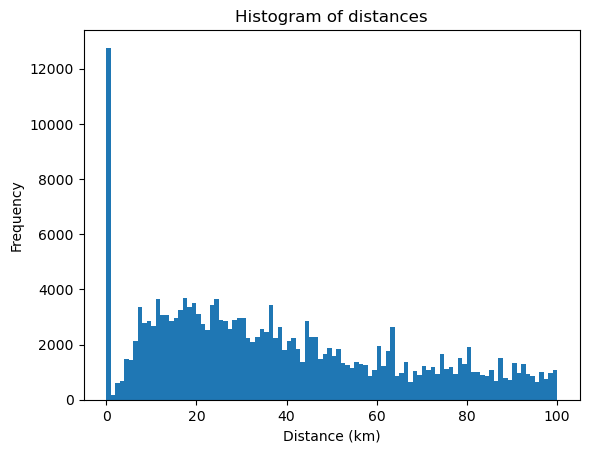

In [35]:
# Histogram of distances
plt.hist(df_direct_matching["distance_km"], bins=100)
plt.xlabel("Distance (km)")
plt.ylabel("Frequency")
plt.title("Histogram of distances")
plt.show()

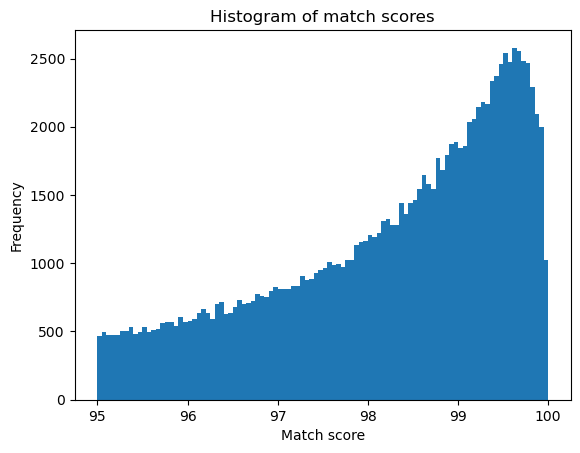

In [36]:
# Histogram of match scores from 95
plt.hist(df_direct_matching["match_score"], bins=100, range=(95, 100))
plt.xlabel("Match score")
plt.ylabel("Frequency")
plt.title("Histogram of match scores")
plt.show()

In [37]:
# Null values
null_values = df_direct_matching.isnull().sum()
print(null_values)

cand_id                           0
job_id                            0
distance_km                       0
match_score                       0
match_rank                        0
cand_gender                       0
cand_age_bucket                   0
cand_domicile_province         2839
cand_domicile_region             20
cand_education               122829
cand_languages_spoken        121745
job_contract_type                 0
job_professional_category       590
job_sector                      598
job_work_province             23853
dtype: int64


In [38]:
len(df_direct_matching)

193474

In [39]:
# Remove rows with null values in columns = ['cand_age_bucket', 'cand_domicile_province', 'cand_domicile_region']
df_direct_matching = df_direct_matching.dropna(
    subset=["cand_age_bucket", "cand_domicile_province", "cand_domicile_region","job_professional_category","job_sector","job_work_province"]  #job_work_province
)

In [40]:
# Print types of columns
print(df_direct_matching.dtypes)

cand_id                       object
job_id                        object
distance_km                  float64
match_score                  float64
match_rank                     int64
cand_gender                   object
cand_age_bucket               object
cand_domicile_province        object
cand_domicile_region          object
cand_education                object
cand_languages_spoken         object
job_contract_type             object
job_professional_category     object
job_sector                    object
job_work_province             object
dtype: object


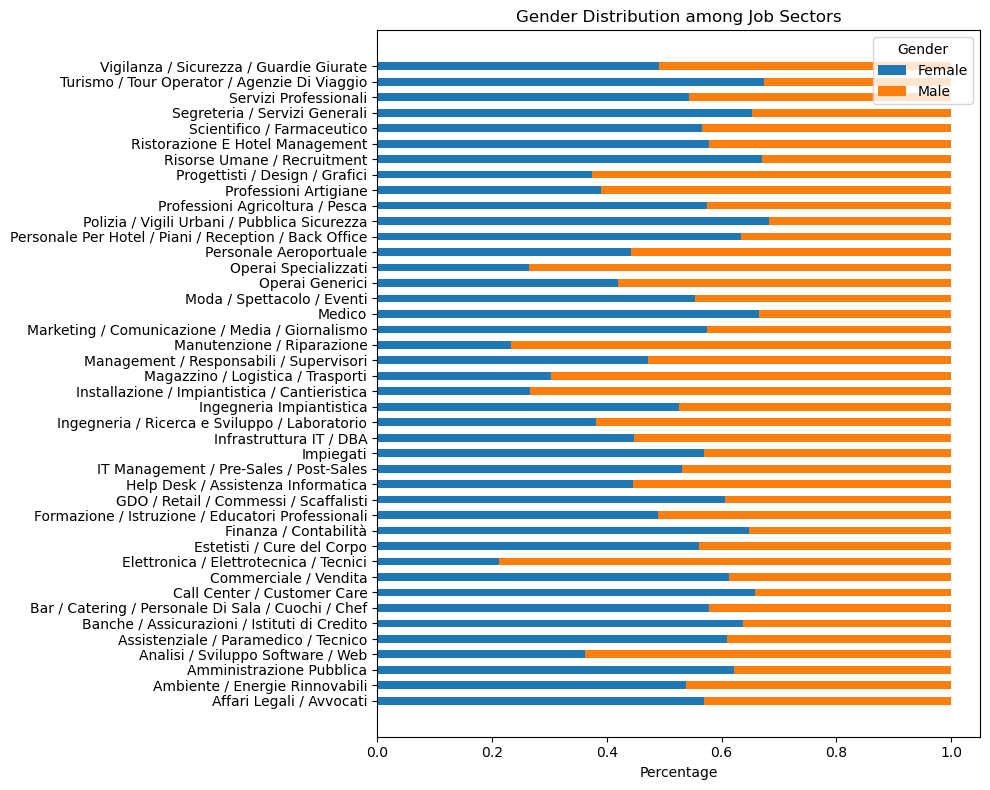

In [41]:
# Visualize gender distribution
f.plot_gender_distribution(df_direct_matching, "job_sector", "cand_gender")

In [42]:
if is_reverse: #extract jobs with at least 7 candidates
    jobs_counts = df_direct_matching.groupby("job_id").size()
    valid_job_ids = jobs_counts[jobs_counts >= 7].index
    df_direct_matching = df_direct_matching[df_direct_matching["job_id"].isin(valid_job_ids)]

# Preprocessing

In [ ]:
df_processed = f.process_full_dataset(df_direct_matching, dataset)

In [44]:
df_processed.to_csv(f"Data/{dataset}_processed.csv", sep=";", index=False)